# Desarrollo del Software Critico. Práctica 1
# **Detección de Anomalías con Machine Learning**
---

## **1. Construcción de modelo LSTM y detección de anomalías**
**En este apartado vamos a crear un modelo básico de red neuronal LSTM (Long Short-Term Memory).**

- Ejecutamos el siguiente comando para hacer que las gráficas sean interactivas:

In [1]:
%matplotlib widget

- Importamos todas las librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input

from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.ensemble import IsolationForest

### **1. En primer lugar, cargamos los datos del archivo `datos.csv` en un DataFrame de Pandas y los comprobamos.**

In [3]:
# Cargar los datos
df = pd.read_csv("../datos.csv",index_col=0,parse_dates=True)
# Check the shape of the dataframe (exluding the index column) :
print("Dimensiones del DataFrame de datos: ", df.shape) # (7267,1) (según el fichero cambiará el número de filas)
df

Dimensiones del DataFrame de datos:  (7267, 1)


,value
timestamp,
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551
...,...
2014-05-28 11:00:00,72.370206
2014-05-28 12:00:00,72.172956
2014-05-28 13:00:00,72.046565


Visualizamos los datos del DataFrame en una gráfica.

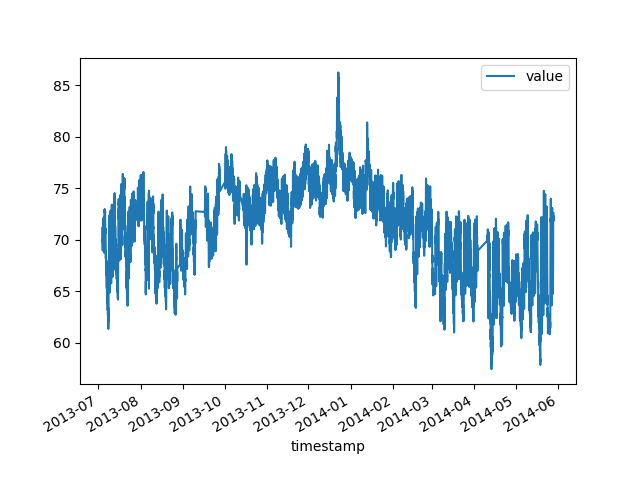

In [4]:
df.plot()
plt.show()



### **2. En segundo lugar, construimos el modelo LSTM**
Vamos a desarrollar un modelo LSTM (Long Short-Term Memory) capaz de realizar predicciones a partir de secuencias de valores de un tamaño determinado (ventana). Es decir, entrenaremos el modelo para que aprenda a estimar el valor más probable que sigue a una ventana dentro de una secuencia temporal.  

Para ello, debemos dividir el conjunto de datos original en datos de entrenamiento. En concreto, se generarán dos subconjuntos:  

- uno que contenga todas las ventanas deslizantes de un tamaño definido (`X`)

- otro con los valores que siguen a cada una de esas ventanas (`y`)  

El modelo tomará como entrada el conjunto `X` y tratará de predecir los valores correspondientes en `y`.  
  
En este caso, el tamaño óptimo de la ventana deslizante se ha fijado en 10 unidades.

* Definimos una función `split_sequence()` que se encarga de dividir el conjunto de datos original en los arrays X e y, separando las ventanas de entrada de sus valores objetivo correspondientes.

In [5]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()

	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
		
	return np.array(X), np.array(y)


* Preparamos los datos de entrada para el modelo

In [6]:
# Convertimos la columna del DataFrame a un array numpy
raw_seq = df['value'].to_numpy()

# Definicion del tamanio de la ventana
n_steps = 10 

# dividimos el conjunto de datos original en los arrays X e y
X, y = split_sequence(raw_seq, n_steps)

# comprobamos las dimensiones de los arrays resultantes
print("Dimensiones de X: ", X.shape) 
print("Dimensiones de y: ", y.shape) 

Dimensiones de X:  (7257, 10)
Dimensiones de y:  (7257,)


* Redimensionamos los datos para adaptarlos al formato de entrada requerido por la red neuronal, el cual debe tener la forma [samples, timesteps, features].

In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # analizamos una sola variable (temperatura)

X = X.reshape((X.shape[0], X.shape[1], n_features))

# comprobamos las dimensiones del array X redimensionado
print("Dimensiones de X redimensionado: ", X.shape) 

Dimensiones de X redimensionado:  (7257, 10, 1)


* Definimos la arquitectura interna del modelo.  
En este caso, utilizamos 10 neuronas con la función de activación ReLU y la función de pérdida MSE (Mean Squared Error) como criterio de optimización.

In [8]:
# Creamos la RNN
model_1 = Sequential()
model_1.add(Input(shape=(n_steps, n_features)))
model_1.add(LSTM(10, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

* Entrenamos el modelo utilizando los dos conjuntos de datos (las ventanas de entrada `X` y sus valores correspondientes `y`).
Se emplean únicamente 10 épocas de entrenamiento, ya que se observa que a partir de la cuarta época la función de pérdida deja de mejorar significativamente.

In [9]:
# fit model (Entrenar la RNN)
model_1.fit(X, y, epochs=10)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1304.3256
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9192
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9234
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8950
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8827
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8730
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8824
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8884
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8678
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9231


* Realizamos una predicción utilizando una ventana de prueba.

In [10]:
# Probamos para los primeros 10 valores del dataset
x_input = np.array([69.88083514, 71.22022706, 70.87780496, 68.95939994, 69.28355102, 70.06096581, 69.27976479, 69.36960846, 69.16671394, 68.98608257])

# redimensionamos la entrada
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_1.predict(x_input, verbose=0)
print("Y hat: " , yhat , " Valor real: 68.98608257" )

Y hat:  [[68.99048]]  Valor real: 68.98608257


### **3. En tercer lugar, realizamos la predicción y detectamos las anomalías**

* Preparamos los datos para realizar la predicció de todo el conjunto inicial, asegurando que tengan el formato adecuado para la entrada del modelo.

In [11]:
# Ignoramos los primeros valores correspondientes al tamaño de la ventana
window_size = n_steps

# Obtenemos las fechas correspondientes a los datos de test (ignorando las primeras 'window_size' fechas)
fechas_test = df[window_size:].index.to_numpy() 

# Comprobamos las dimensiones del array de fechas de test
print("Dimension de fechas_test: " , fechas_test.shape) 


Dimension de fechas_test:  (7257,)


* Realizamos la predicción de todos los valores a partir de la posición window_size + 1, proporcionando únicamente X como entrada al modelo.

In [12]:
y_pred = model_1.predict(X, verbose=0)
# comprobamos las dimensiones del array de predicciones
print("Dimensiones de y_pred: ", y_pred.shape)
y_pred


Dimensiones de y_pred:  (7257, 1)


array([[68.990486],
       [69.73874 ],
       [70.34556 ],
       ...,
       [71.94933 ],
       [71.93109 ],
       [71.73204 ]], shape=(7257, 1), dtype=float32)

* Adaptamos la secuencia de datos de prueba al tamaño de la predicción, omitiendo la primera ventana.

In [13]:
# Valores reales de test
y_test=df["value"][window_size:]
print(y_test)

timestamp
2013-07-04 10:00:00    69.965062
2013-07-04 11:00:00    70.556195
2013-07-04 12:00:00    70.307505
2013-07-04 13:00:00    70.246252
2013-07-04 14:00:00    69.854908
                         ...    
2014-05-28 11:00:00    72.370206
2014-05-28 12:00:00    72.172956
2014-05-28 13:00:00    72.046565
2014-05-28 14:00:00    71.825226
2014-05-28 15:00:00    72.584089
Name: value, Length: 7257, dtype: float64


Para detectar las anomalías, primero calculamos el error absoluto entre los valores predichos y los valores reales.
A continuación, consideramos como anomalías aquellos casos cuyo error supera el percentil 99 de la distribución de errores.  
  
Se ha elegido este criterio porque permite identificar las anomalías de manera más precisa.

In [14]:
# Calculamos la diferencia absoluta entre los valores reales y las predicciones
absolute_errors = np.abs(y_test.to_numpy() - y_pred.flatten())

# Calculamos la media de los errores absolutos
mae = np.mean(absolute_errors)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.7230284743073876


In [15]:
# Calulamos el valor umbral correspondiente al percentil 99 
# Solo el 1% de los errores serán mayores que este valor y se considerarán anomalías
threshold = np.percentile(absolute_errors, 99)
print("Threshold: ", threshold)

Threshold:  2.2754941921195293


Calculamos el array de valores booleanas Correspondientes a anomalías.

In [16]:
anomalies = absolute_errors > threshold # boolean array indicating anomalies
count = anomalies.sum() 
print(f"Numero de anomalias detectado: {count}")


Numero de anomalias detectado: 73


* Representamos en una gráfica los datos originales, los valores predichos y las anomalías detectadas.

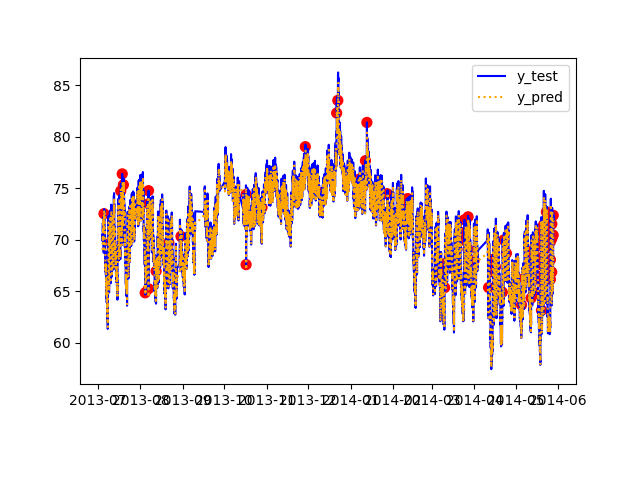

In [17]:
plt.clf() # Clear the current figure

plt.plot(fechas_test, y_test, color='blue', label='y_test')
plt.plot(fechas_test, y_pred, color='orange', linestyle='dotted', label='y_pred')
plt.scatter(x=fechas_test, y=y_test, c='red', alpha=anomalies.astype(int), s=50)

plt.legend()
plt.show()

Al analizar la gráfica, podemos observar que el modelo predice con gran precisión la secuencia temporal; sin embargo, aún así detecta un número considerable de anomalías.  
 
---
  
    

## **2. Autoencoder**
**En este apartado, vamos a utilizar un modelo autoencoder basado en LSTM para la detección de anomalías.**

Definimos una función similar a la del apartado anterior, que se encarga de dividir el conjunto de datos original en ventanas, ya que el autoencoder toma como entrada una ventana de tamaño definido.
Posteriormente, tras codificar y decodificar dicha ventana, el modelo devuelve una versión reconstruida con el mismo tamaño.
De este modo, `X` estará formado por todas las ventanas deslizantes generadas a partir del conjunto de datos original.

In [18]:
def split_sequence_X(sequence, n_steps):
	X = list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x = sequence[i:end_ix]
		X.append(seq_x)
		
	return np.array(X)

* Definimos la secuencia de entrada de forma análoga al primer apartado.

In [19]:
# convertimos la columna del df a array numpy
sequence = df['value'].to_numpy() 

# definimos el tamaño de la ventana
window_size = 10

# dividimos la secuencia en ventanas
x_input = split_sequence_X(sequence, window_size)

n_features = 1

# comprobamos las dimensiones del array resultante
print(x_input.shape)

# redimensionamos el array de entrada para cumplir con la forma: [samples, timesteps, features]
X_input = x_input.reshape((x_input.shape[0], x_input.shape[1], n_features))

# comprobamos las dimensiones del array resultante
print(X_input.shape)

(7257, 10)
(7257, 10, 1)


* Definimos la arquitectura interna del autoencoder.
En este caso, se utilizan 100 neuronas en el encoder y 100 en el decoder, ambas con la función de activación ReLU, y se emplea la función de pérdida MSE (Mean Squared Error) como criterio de optimización.

El autoencoder de ventana deslizante (en nuestro caso de tamño 10) procesa secuencias temporales dividiéndolas en ventanas consecutivas de 10 valores.
Cada ventana se introduce en el encoder, que comprime la información en una representación de menor dimensión y posteriormente el decoder intenta reconstruir la secuencia original a partir de dicha representación. Esto se repite para cada ventana

In [20]:
# define model
model_2 = Sequential()
model_2.add(Input(shape=(window_size, n_features)))
model_2.add(LSTM(100, activation='relu'))
model_2.add(RepeatVector(window_size))
model_2.add(LSTM(100, activation='relu', return_sequences=True))
model_2.add(TimeDistributed(Dense(1)))

model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

* Entrenamos el modelo utilizando el conjunto de datos de entrada (X).
Se considera suficiente un entrenamiento de 10 épocas, ya que el modelo converge adecuadamente en ese intervalo.

In [21]:
# fit model
model_2.fit(X_input, X_input, epochs=10)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 60.2158 
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6125
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4508
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4232
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4124
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4118
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4123
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3877
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4186
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3759


* Generamos el conjunto de ventanas reconstruidas por el decoder, correspondientes a las salidas del autoencoder tras el proceso de decodificación.

In [22]:
X_pred = model_2.predict(X_input, verbose=0)

print(X_pred.shape) # devielve 7257 ventanas de 10 valores ( y con 1 feature )

(7257, 10, 1)


* Redimensionamos la salida del modelo aplicando la media de los valores predichos para cada posición, ya que cada punto de la secuencia fue estimado por múltiples ventanas superpuestas.

In [23]:
# Eliminamos la dimensión de características (1) y promediamos las predicciones superpuestas
X_pred_2d = X_pred.squeeze() 

X_pred_avrg = np.mean(X_pred_2d, axis=1)
X_pred_avrg.shape

(7257,)

* Ajustamos el tamaño de los datos de prueba, ya que para algunos valores situados al inicio y al final de la secuencia no ha sido posible calcular la media.

In [24]:
borders = window_size // 2
Y_test = sequence[window_size // 2 :-(window_size // 2)]
Y_test.shape

(7257,)

* Representamos en una gráfica los valores reconstruidos por el autoencoder junto con los valores originales.

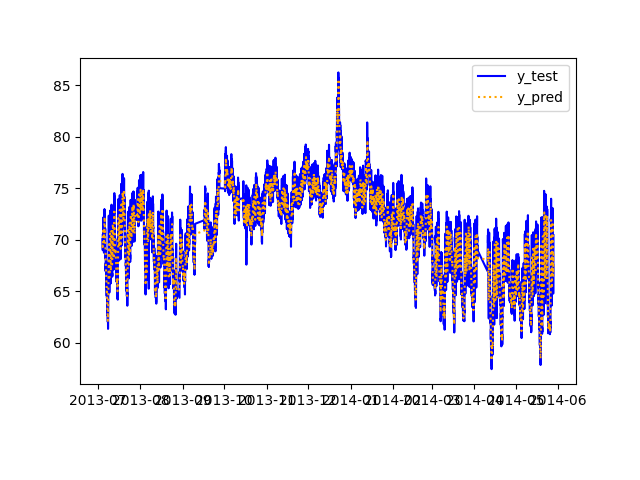

In [25]:
plt.clf() # Clear the current figure

plt.plot(fechas_test, Y_test, color='blue', label='y_test')
plt.plot(fechas_test, X_pred_avrg, color='orange', linestyle='dotted', label='y_pred')

plt.legend()
plt.show()

### **Deteccion de anomalías**
Para detectar las anomalías, calculamos el error cuadrático entre todos los valores de las ventanas predichas y los valores originales correspondientes.

In [26]:
squared_difference = np.square(X_pred - X_input)
squared_difference.shape

(7257, 10, 1)

In [27]:
reconstruction_errors = np.mean(squared_difference, axis=(1, 2))
reconstruction_errors.shape

(7257,)

- Al igual que en el apartado anterior, consideramos como anomalías aquellas ventanas cuyo error supera el percentil 99 de la distribución.

In [28]:
# Set the percentile (e.g., 99 for 1% expected anomalies)
percentile_value = 99 

# Calculate the threshold
anomaly_threshold = np.percentile(reconstruction_errors, percentile_value)

print(f"Threshold del percentile {percentile_value}: {anomaly_threshold:.4f}")

Threshold del percentile 99: 1.5429


* Creamos el array de anomalías.

In [29]:
anomaly_bool = reconstruction_errors > anomaly_threshold
anomaly_bool.shape

(7257,)

- Representamos en una gráfica los valores identificados como anómalos.

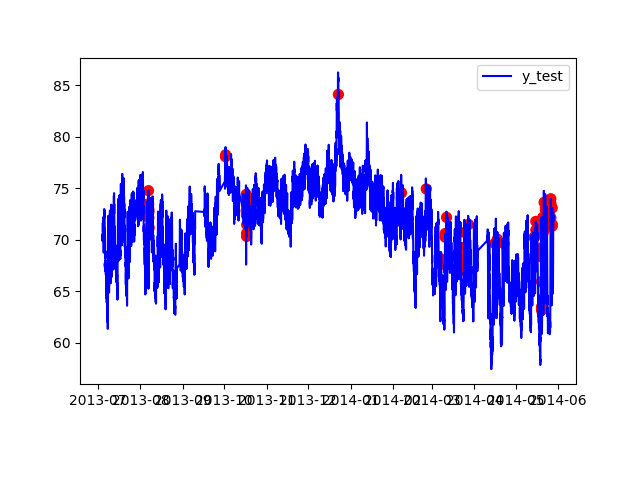

In [30]:
plt.clf() # Clear the current figure

plt.plot(fechas_test, y_test, color='blue', label='y_test')
plt.scatter(x=fechas_test, y=y_test, c='red', alpha=anomaly_bool.astype(int), s=50)

plt.legend()
plt.show()

- A partir de la gráfica, se observa que este modelo detecta las anomalías con mayor precisión que el modelo anterior.

---

## **3. Isolation forest**
**En este apartado, vamos a utilizar la tecnica de Isolation Forest para la detección de anomalías.**

In [31]:
# Volvemos a cargar los datos
data = df.values
data.shape

(7267, 1)

- Construimos el modelo Isolation Forest con 100 árboles, estableciendo un porcentaje esperado de anomalías del 1 % y una semilla aleatoria para garantizar la reproducibilidad de los resultados

In [32]:
model_3 = IsolationForest(n_estimators=100, contamination=0.01, random_state=12)

- Entrenamos el modelo con todo el conjunto de datos.

In [33]:
model_3.fit(data)

,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,12
,verbose,0
,warm_start,False


- Realizamos la predicción y le dictamos las anomalías.

In [34]:
# Predict anomalies (-1 for outliers, 1 for inliers)
y = model_3.predict(data)

# Filtramos la anomalías
anomalies = (y == -1)

fechas_test = df.index[:]


anomalies.shape


(7267,)

- Representamos los resultados en la gráfica

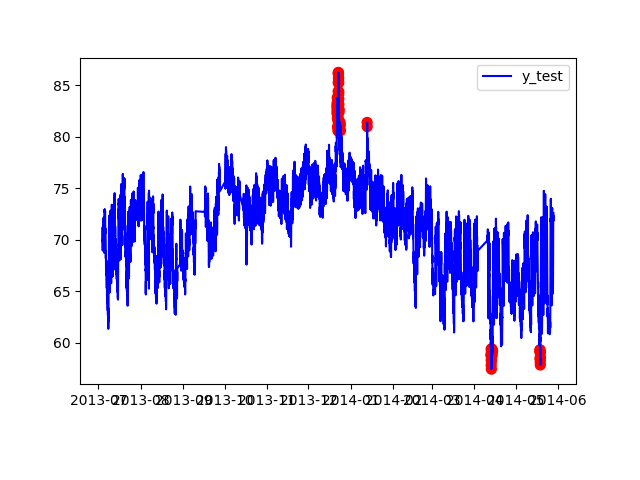

In [35]:
plt.clf() # Clear the current figure

plt.plot(fechas_test, data, color='blue', label='y_test')
plt.scatter(x=fechas_test, y=data, c='red', alpha=anomalies.astype(int), s=50)

plt.legend()
plt.show()